In [632]:
import dataset as ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [633]:
CUTOFF = 10000

In [634]:
exp_name = "twitter15"

In [635]:
data_builder = ds.DatasetBuilder(exp_name, time_cutoff=CUTOFF)
dataset = data_builder.create_dataset(dataset_type="raw", standardize_features=False)

Considering 4 classes problem
We consider tweets emitted no later than 10000mins after the root tweet
Features that will be considered: user_only
Len train/val/test 1005 149 336
Oversampling...
Before oversampling: 1490 trees, 1005 train trees
After oversampling: 1490 trees, 1005 train trees
Dataset loaded in 38.045s


In [636]:
raw_train = dataset['train']
raw_validate = dataset['val']
raw_test = dataset['test']

In [637]:
len(raw_train)

1005

In [638]:
# raw_train[0][0]

In [639]:
edge_feature_names = ["created_at",
                    "favourites_count", 
                    "followers_count", 
                    "friends_count", 
                    "geo_enabled",
                    "has_description",
                    "len_name",
                    "len_screen_name",
                    "listed_count",
                    "statuses_count", 
                    "verified"
                     ]
edge_feature_names = sorted(edge_feature_names)
edge_feature_names = ["label",
                      "root_id",
                      "in_tweet_idx",
                      "out_tweet_idx",
                      "latency",
                      "in_uid",
                      "out_uid"] + edge_feature_names
n_cols = len(edge_feature_names)
n_cols

18

In [640]:
# edge_feature_names

In [641]:
PREDICTION_LATENCY = 120 # in minutes after the first tweet is emitted

In [642]:
def get_df_from_raw(raw_data):
    data_dict = {name:[] for name in edge_feature_names}
    for features_sequence in raw_data:
        for dp in features_sequence:
            for i in range(n_cols):
                data_dict[edge_feature_names[i]].append(dp[i])
    df = pd.DataFrame(data=data_dict)
    return df

In [643]:
df_train = get_df_from_raw(raw_train)
df_validate = get_df_from_raw(raw_validate)
df_test = get_df_from_raw(raw_test)

In [644]:
df_train.head()

,label,root_id,in_tweet_idx,out_tweet_idx,latency,in_uid,out_uid,created_at,favourites_count,followers_count,friends_count,geo_enabled,has_description,len_name,len_screen_name,listed_count,statuses_count,verified
0,non-rumor,766358933296517121,0,1,0.22,428333,2513357536,16187.0,188559.0,617.0,4134.0,0.0,1.0,8.0,6.0,39.0,98835.0,0.0
1,non-rumor,766358933296517121,0,2,0.22,428333,19770652,14274.0,75.0,514.0,733.0,0.0,1.0,13.0,8.0,32.0,456.0,0.0
2,non-rumor,766358933296517121,0,3,0.23,428333,751437827364229120,15294.0,5506.0,421.0,487.0,0.0,0.0,11.0,11.0,8.0,13318.0,0.0
3,non-rumor,766358933296517121,0,4,0.25,428333,137436023,14725.0,6163.0,11887.0,11950.0,1.0,1.0,19.0,12.0,94.0,33441.0,0.0
4,non-rumor,766358933296517121,0,5,0.25,428333,25224705,14322.0,18342.0,8798.0,2524.0,1.0,1.0,19.0,13.0,162.0,35980.0,0.0


In [645]:
class_labels = list(df_train.label.unique())
lookup_dict = {label:integer for integer, label in enumerate(class_labels)}

In [646]:
class_labels

['non-rumor', 'false', 'true', 'unverified']

In [647]:
list(lookup_dict.items())

[('non-rumor', 0), ('false', 1), ('true', 2), ('unverified', 3)]

In [648]:
len(df_train.in_tweet_idx.unique())

2316

In [649]:
# df_train.label

In [650]:
# df_test = df_train.groupby(['out_uid']).nunique().loc[:, ['label', 'favourites_count']]
# df_test.favourites_count.unique()

In [651]:
to_log = ['favourites_count', 'followers_count', 'friends_count', 'statuses_count']
for colname in to_log:
    df_train.loc[:, colname] = np.log(df_train.loc[:, colname].values + 1)
    df_validate.loc[:, colname] = np.log(df_validate.loc[:, colname].values + 1)
    df_test.loc[:, colname] = np.log(df_test.loc[:, colname].values + 1)
df_train.label = df_train.label.apply(lambda x: lookup_dict[x])
df_validate.label = df_validate.label.apply(lambda x: lookup_dict[x])
df_test.label = df_test.label.apply(lambda x: lookup_dict[x])

In [652]:
# df_train.dtypes

In [653]:
def cut_by_latency(df):
    df = df.loc[df.latency <= PREDICTION_LATENCY]
    return df

In [654]:
# df_train = cut_by_latency(df_train)
# df_validate = cut_by_latency(df_validate)
# df_test = cut_by_latency(df_test)

First analysis based on a simple aggregation of the features by root_id
- in_tweet -> nunique
- latency -> mean
- in_uid -> nunique
- created_at -> mean
- followers_count -> mean
- favourites_count -> mean
- friends_count -> mean
- geo_enabled -> mean
- has_description -> mean
- statuses_count -> mean
- verified -> mean

In [655]:
df_train.columns

Index(['label', 'root_id', 'in_tweet_idx', 'out_tweet_idx', 'latency',
       'in_uid', 'out_uid', 'created_at', 'favourites_count',
       'followers_count', 'friends_count', 'geo_enabled', 'has_description',
       'len_name', 'len_screen_name', 'listed_count', 'statuses_count',
       'verified'],
      dtype='object')

In [656]:
cols_kept = [colname for colname in df_train.columns if colname not in ['len_name', 'len_screen_name', 'listed_count']]
# cols_kept

In [657]:
count_cols = ['out_tweet_idx', 'out_uid', 'in_tweet_idx', 'in_uid']

In [658]:
mean_cols = [colname for colname in cols_kept if (colname not in count_cols and colname !='root_id')]

In [659]:
sum_cols = []
sum_cols

[]

In [660]:
print(len(cols_kept), len(mean_cols), len(count_cols), len(sum_cols))

15 10 4 0


In [661]:
df_train = df_train[cols_kept]
df_validate = df_validate[cols_kept]
df_test = df_test[cols_kept]

In [662]:
df_train.head()

,label,root_id,in_tweet_idx,out_tweet_idx,latency,in_uid,out_uid,created_at,favourites_count,followers_count,friends_count,geo_enabled,has_description,statuses_count,verified
0,0,766358933296517121,0,1,0.22,428333,2513357536,16187.0,12.147172,6.426488,8.327243,0.0,1.0,11.501217,0.0
1,0,766358933296517121,0,2,0.22,428333,19770652,14274.0,4.330733,6.244167,6.598509,0.0,1.0,6.124683,0.0
2,0,766358933296517121,0,3,0.23,428333,751437827364229120,15294.0,8.613775,6.045005,6.190315,0.0,0.0,9.496947,0.0
3,0,766358933296517121,0,4,0.25,428333,137436023,14725.0,8.726481,9.383285,9.388570,1.0,1.0,10.417568,0.0
4,0,766358933296517121,0,5,0.25,428333,25224705,14322.0,9.817003,9.082393,7.833996,1.0,1.0,10.490746,0.0


In [663]:
def aggregation_v0(df):
    aggregations_dict = {name:'sum' for name in sum_cols}
    aggregations_dict.update({name: 'mean' for name in mean_cols})
    aggregations_dict.update({name: 'nunique' for name in count_cols})
    aggregated_data = df.groupby('root_id').agg(aggregations_dict)
    aggregated_data = aggregated_data.reset_index()
#     aggregated_data = aggregated_data.drop(columns='root_id')
    return aggregated_data

### We aggregate the features as planned and fit a GB with Decision Trees model, evaluate its ROC-AUC perf on val

In [664]:
df_train = aggregation_v0(df_train)
df_validate = aggregation_v0(df_validate)
df_test = aggregation_v0(df_test)

In [665]:
len(df_train)

1002

In [666]:
df_train.head()

,root_id,label,latency,created_at,favourites_count,followers_count,friends_count,geo_enabled,has_description,statuses_count,verified,out_tweet_idx,out_uid,in_tweet_idx,in_uid
0,80080680482123777,1,90.784400,14454.830000,6.930201,6.397433,6.380664,0.590000,0.840000,9.179843,0.020000,100,100,4,4
1,265953285247209472,1,129.383223,14736.184834,7.759638,5.495381,6.067609,0.540284,0.772512,8.814724,0.018957,211,211,7,7
2,295152287901417472,2,460.343366,15221.970297,7.708395,6.780317,6.337940,0.485149,0.742574,9.897010,0.000000,101,101,4,4
3,295944137948151809,1,2326.193416,15043.471537,7.993260,6.008538,5.872666,0.605313,0.727704,9.530526,0.001898,1053,1053,158,158
4,318263294098030593,1,1390.860437,15151.487624,7.827639,5.801351,5.578781,0.570132,0.710396,9.302484,0.000825,1212,1212,189,189


In [667]:
def binned_plot(data, feature_col, target_col, nquantiles=5):
    feature_vals = data.loc[:, feature_col].values
    target_vals = data.loc[:, target_col].values
    quantiles_to_compute = np.linspace(0, 1, num=nquantiles+2)
    bin_edges = np.quantile(feature_vals, q=quantiles_to_compute)
    nx, _ = np.histogram(feature_vals, bins=bin_edges)
    sum_x, _ = np.histogram(feature_vals, bins=bin_edges, weights=feature_vals)
    sum_y, _ = np.histogram(feature_vals, bins=bin_edges, weights=target_vals)
    plt.plot(sum_x / nx, sum_y/nx, color='black')
    plt.xlabel('Feature {}'.format(feature_col))
    plt.ylabel('Target mean')
    plt.ylim(target_vals.min(), target_vals.max())
    plt.grid()
    plt.show()
    plt.close()

In [668]:
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score

In [669]:
dataset = lgb.Dataset(df_train.drop(columns='root_id').iloc[:, 1:], label=df_train.label)
dataset.construct()
params = {
    'objective':'multiclass',
    'num_class':4,
    'bagging_freq':5,
    'feature_fraction':1.0,
    'boosting_type':'gbdt',
    'max_depth':5,
    'learning_rate':0.005, # range tested is 0.001, 0.01, 0.005
    'n_estimators':2000,# range tested is 1000, 2000
    'verbosity':2
    }

gbm_model = lgb.train(params, train_set=dataset)

In [670]:
def return_accuracy(data, model):
    preds = model.predict(data.drop(columns='root_id').iloc[:, 1:], raw_score=False).argmax(1)
    return accuracy_score(data.label.values, preds)

In [671]:
print(f"LighGBM_user, {exp_name}, {params['learning_rate']}, {params['n_estimators']}, {return_accuracy(df_train, gbm_model):.4f}, {return_accuracy(df_validate, gbm_model):.4f}, {return_accuracy(df_test, gbm_model):.4f}")

LighGBM_user, twitter15, 0.005, 2000, 0.9621, 0.6284, 0.6280


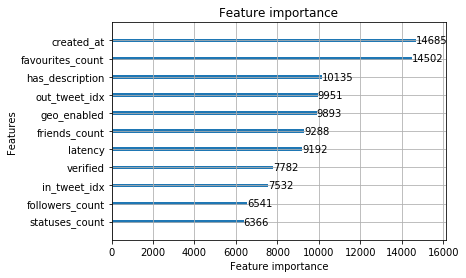

In [672]:
lgb.plot_importance(gbm_model)

### Text features from MLP

In [673]:
import torch
import torch.nn as nn

In [674]:
data_builder = ds.DatasetBuilder(exp_name, time_cutoff=CUTOFF, features_to_consider='text_only')
dataset = data_builder.create_dataset(dataset_type="raw", standardize_features=False)

Considering 4 classes problem
We consider tweets emitted no later than 10000mins after the root tweet
Features that will be considered: text_only
Len train/val/test 1005 149 336
Oversampling...
Before oversampling: 1490 trees, 1005 train trees
After oversampling: 1490 trees, 1005 train trees
Dataset loaded in 73.499s


In [675]:
def to_dataset(raw_dt):
    mlp_data = [tree[0] for tree in raw_dt if len(tree)]
    mlp_data = np.stack([np.array([dp[1], lookup_dict[dp[0]]] + dp[7:]) for dp in mlp_data])
    return mlp_data

In [676]:
train_mlp = to_dataset(dataset['train'])
val_mlp = to_dataset(dataset['val'])
test_mlp = to_dataset(dataset['test'])

In [677]:
np.unique(train_mlp[:, 1])

array([0., 1., 2., 3.])

In [678]:
n_hidden_layers = 3
hidden_size = 24
batch_size = 64
lr = 0.0005
# dropout_prob =0.5
n_epochs = 500 if exp_name == 'twitter15' else 100

In [679]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [680]:
model_seq = []
model_seq.append(nn.Linear(in_features=768, out_features=hidden_size))
for _ in range(n_hidden_layers):
#     model_seq.append(nn.Dropout(dropout_prob))
    model_seq.append(nn.Linear(in_features=hidden_size, out_features=hidden_size))
model_seq.append(nn.Linear(in_features=hidden_size, out_features=4))
mlp = nn.Sequential(*model_seq)
mlp = mlp.to(device)

In [681]:
optim = torch.optim.Adam(mlp.parameters(), lr=lr) #[param for name, param in mlp.named_parameters()]

In [682]:
train_loader = torch.utils.data.DataLoader(train_mlp[:, 1:], batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_mlp[:, 1:], batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_mlp[:, 1:], batch_size=batch_size, shuffle=True)

In [683]:
def eval_loader(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for dp in loader:
            y = dp[:, 0].to(device).long()
            x = dp[:, 1:].to(device).float()
            logits = mlp(x)
            _, preds = logits.max(dim=1)
            correct += float(preds.eq(y).sum().item())
            total += y.size(0)
    return correct / total

In [684]:
loss_func = nn.CrossEntropyLoss(reduction='mean')
for epoch in range(n_epochs):
    epoch_loss = 0.
    
    #TRAIN
    mlp.train()
    for dp in train_loader:
        y = dp[:, 0].to(device).long()
        x = dp[:, 1:].to(device).float()
        logits = mlp(x)

        
        loss = loss_func(logits, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss.item()
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}: Mean Loss = {epoch_loss/len(train_loader):.3f}")
        
    
    #EVAL
    if (epoch+1) % 100 == 0:
        print(f"Accuracy Epoch {epoch+1} on Val: {eval_loader(mlp, val_loader):.3f}")

Epoch 100: Mean Loss = 0.437
Accuracy Epoch 100 on Val: 0.561
Epoch 200: Mean Loss = 0.145
Accuracy Epoch 200 on Val: 0.541
Epoch 300: Mean Loss = 0.138
Accuracy Epoch 300 on Val: 0.568
Epoch 400: Mean Loss = 0.139
Accuracy Epoch 400 on Val: 0.561
Epoch 500: Mean Loss = 0.139
Accuracy Epoch 500 on Val: 0.568


In [685]:
print(f"MLPtext, {exp_name}, {n_epochs}, {batch_size}, {lr}, {hidden_size}, {n_hidden_layers}, {eval_loader(mlp, train_loader):.4f}, {eval_loader(mlp, val_loader):.4f}, {eval_loader(mlp, test_loader):.4f}")

MLPtext, twitter15, 500, 64, 0.0005, 24, 3, 0.9311, 0.5676, 0.5357


### SEIZ features

In [686]:
seiz_train = pd.read_csv(f'seiz_dataset_{exp_name}.csv')
seiz_val = pd.read_csv(f"seiz_dataset_{exp_name}_val.csv")
seiz_test = pd.read_csv(f"seiz_dataset_{exp_name}_test.csv")

In [687]:
init_pops = ['S0', 'E0', 'I0', 'Z0']
def transform_seiz_data(input_data):
    #Computing R score
    df = input_data.copy()
    p = df.p.values
    beta = df.beta.values
    l = df.l.values
    rho = df.rho.values
    epsilon = df.epsilon.values
    b = df.b.values
    df['R'] = ((1 - p) * beta + (1 - l) * b) / (rho + epsilon)
    # Normalizing population columns
    df['N'] = df[init_pops].values.sum(1)
    for col in init_pops:
        df[col] = df[col].values / df['N'].values
    df = df.drop(columns='N')
    #Incubation time is relevant
    df['incubation_time'] = 1 / df.epsilon.values
    #Encode target as category for lightgbm
    df.label = df.label.apply(lambda x: lookup_dict[x])
    df = df.rename(columns={'ID':'root_id'})
    return df

In [688]:
seiz_train = transform_seiz_data(seiz_train)
seiz_val = transform_seiz_data(seiz_val)
seiz_test = transform_seiz_data(seiz_test)

In [689]:
seiz_train.head()

,label,root_id,beta,b,rho,epsilon,l,p,S0,E0,I0,Z0,RMSE_fit,R,incubation_time
0,0,766358933296517121,1.184614e-08,2.919292e-02,0.000009,0.133782,0.274173,2.377177e-01,0.047004,0.030854,0.000757,0.921385,6.027130,0.158374,7.474838
1,1,516636338679197697,4.486586e-02,2.815412e-19,0.999991,0.022433,0.994876,8.552127e-09,0.234612,0.154795,0.003754,0.606840,2.371241,0.043882,44.576673
2,1,532007252677656576,4.729451e-02,2.151658e-02,1.000000,0.047094,0.570550,9.458806e-01,0.572296,0.245931,0.004174,0.177599,2.485369,0.011269,21.234216
3,2,514109888138842113,9.995275e-01,1.902343e-01,0.008715,0.010761,0.987966,9.617912e-01,0.255202,0.003802,0.000462,0.740534,1.413663,2.078515,92.932122
4,3,724348906096590849,4.579414e-07,2.269379e-02,0.347807,0.119594,0.423954,2.723150e-01,0.054405,0.021872,0.000173,0.923550,2.093939,0.027970,8.361631


In [690]:
dataset_seiz = lgb.Dataset(seiz_train.iloc[:, 1:].drop(columns='root_id'), label=seiz_train.label)
dataset_seiz.construct()
params_seiz = {
    'objective':'multiclass',
    'num_class':4,
    'bagging_freq':5,
    'feature_fraction':1.0,
    'boosting_type':'gbdt',
    'max_depth':5,
    'learning_rate':0.001, # range tested is 0.001, 0.01, 0.005
    'n_estimators':2000,# range tested is 1000, 2000
    'verbosity':2
    }
gbm_model_seiz = lgb.train(params_seiz, train_set=dataset_seiz)

In [691]:
print(f"LighGBM_seiz, {exp_name}, {params_seiz['learning_rate']}, {params_seiz['n_estimators']}, {return_accuracy(seiz_train, gbm_model_seiz):.4f}, {return_accuracy(seiz_val, gbm_model_seiz):.4f}, {return_accuracy(seiz_test, gbm_model_seiz):.4f}")

LighGBM_seiz, twitter15, 0.001, 2000, 0.6724, 0.4122, 0.3604


### Ensemble model

In [692]:
def seiz_and_user_to_ensemble_dataset(model_seiz, model_user, input_data_user, input_data_seiz):
    preds_user = pd.DataFrame(model_user.predict(input_data_user.drop(columns='root_id').iloc[:, 1:], raw_score=True))
    preds_user.columns = ['user'+str(col) for col in preds_user.columns]
    preds_user = preds_user.join(input_data_user.root_id)
    preds_seiz = pd.DataFrame(model_seiz.predict(input_data_seiz.drop(columns='root_id').iloc[:, 1:], raw_score=True))
    preds_seiz.columns = ['seiz'+str(col) for col in preds_seiz.columns]
    preds_seiz = preds_seiz.join(input_data_seiz.root_id)
    return input_data_user.loc[:, ['label', 'root_id']].merge(preds_user, how='inner', on='root_id').merge(preds_seiz, how='inner', on='root_id')

In [693]:
train_full = seiz_and_user_to_ensemble_dataset(gbm_model_seiz, gbm_model, df_train, seiz_train)
val_full = seiz_and_user_to_ensemble_dataset(gbm_model_seiz, gbm_model, df_validate, seiz_val)
test_full = seiz_and_user_to_ensemble_dataset(gbm_model_seiz, gbm_model, df_test, seiz_test)

In [694]:
train_full.head()

,label,root_id,user0,user1,user2,user3,seiz0,seiz1,seiz2,seiz3
0,1,80080680482123777,-6.747346,-0.156959,-0.563364,-2.332715,-2.551854,-1.355474,-1.129595,-1.225254
1,1,265953285247209472,-6.387118,0.025079,-0.636408,-2.499793,-0.989461,-1.000756,-1.886361,-1.267210
2,2,295152287901417472,-6.267525,-0.978583,0.025178,-1.632125,-2.084975,-1.115194,-0.927093,-1.404249
3,1,295944137948151809,-4.647596,0.854712,-1.911327,-3.555474,-0.826643,-1.418556,-1.732408,-1.819169
4,1,318263294098030593,-5.753547,0.261192,-1.811476,-3.542211,-0.775416,-1.430715,-1.290064,-2.473437


In [695]:
len(train_full), len(df_train), len(seiz_train)

(995, 1002, 995)

In [696]:
dataset_full = lgb.Dataset(train_full.drop(columns='root_id').iloc[:, 1:], label=train_full.label)
dataset_full.construct()
params_full = {
    'objective':'multiclass',
    'num_class':4,
    'bagging_freq':5,
    'feature_fraction':1.0,
    'boosting_type':'gbdt',
    'max_depth':5,
    'learning_rate':0.0001, # range tested is 0.001, 0.01, 0.005
    'n_estimators':2000,# range tested is 1000, 2000
    'verbosity':2
    }
gbm_model_full = lgb.train(params_full, train_set=dataset_full)

In [697]:
print(f"LighGBM_seiz_and_user, {exp_name}, {params_full['learning_rate']}, {params_full['n_estimators']}, {return_accuracy(train_full, gbm_model_full):.4f}, {return_accuracy(val_full, gbm_model_full):.4f}, {return_accuracy(test_full, gbm_model_full):.4f}")

LighGBM_seiz_and_user, twitter15, 0.0001, 2000, 0.9588, 0.6351, 0.5766
